In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy import signal
import time
import datetime
import serial
from scipy.fftpack import fft,ifft
from matplotlib.pylab import mpl
import struct
import os
import serial
from pathlib import Path
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
!python.exe -m PyQt5.uic.pyuic Automated_testingV1.6.ui -o Automated_testingV16.py

In [66]:
!python.exe -m PyQt5.uic.pyuic Automated_testingV1.7.ui -o Automated_testingV17.py

In [229]:
!python.exe -m PyQt5.uic.pyuic Automated_testing.ui -o Automated_testing.py

Error: No such file or directory: "Automated_testing.ui"


In [ ]:
# 生成加密密钥
import uuid
import hashlib
mac = uuid.getnode()
uuids  = ':'.join(('%012X'%mac)[i:i+2] for i in range(0,12,2))
list_groupbox = [
    'groupBox_tools_bd3x_test',
    'groupBox_tools_bd3x_allpara',
    'comboBox_tools_bd3x_preset',
    'comboBox_tools_bd3x_preset'

]
print('本机UUID:{}'.format(uuids))
for i in list_groupbox:
    key = hashlib.md5(( i + uuids + 'yhc2025hashkey').encode("utf-8")).hexdigest()
    print('界面ID:{}, key:{}'.format(i,key))

本机UUID:40:EC:99:76:18:CF
界面ID:groupBox_tools_bd3x_test, key:f135c042e27556db9292f64b2e4b1b27
界面ID:groupBox_tools_bd3x_allpara, key:03f104489fdab0cef02309abbe2bf1aa
界面ID:comboBox_tools_bd3x_preset, key:030c56df3e9c56dd059db021c5f19175
界面ID:comboBox_tools_bd3x_preset, key:030c56df3e9c56dd059db021c5f19175


In [65]:
def init_sdf():
    # 初始化文件
    list_columns = [
        "G0", "G+", "G-", 
        "ScaleFactor+", "ScaleFactor-", "NonLinear", 
        "K*x", "K*y", "K*z", 
        "Temp"
    ]
    list_rows = ["Gx", "Gy", "Gz", "Ax", "Ay", "Az"]
    sdf = pd.DataFrame(0,index=list_rows, columns=list_columns)
    return sdf  
def decode_zfG(zfG_str,A_length=4):
    zfG_list = zfG_str.split(' ')[:3]
    if len(zfG_list)<3:
        zfG_list = [zfG_str[:A_length]]*3
    zfG_decode = []
    for cout,strs in enumerate(zfG_list):
        if strs!=4:
            strs = strs.ljust(4,'0')[:4]
        zfg_list = [[],[]]
        for i in range(A_length):
            if strs[i]=='1':
                zfg_list[0].append(i)
            else:
                zfg_list[1].append(i)
        zfG_decode.append(zfg_list)

    return zfG_decode

paths = 'E:/Work/理工导航/General_autoTest_Host/test_fun/data/all_ave'
names = 'LW_-50_1_s_txt.txt'
para_name = names.split('.txt')[0] + '_para.txt'

df = pd.read_csv(os.path.join(paths, names), encoding='gb2312', delim_whitespace=True)
if df.columns[0].lower() == 'turntable':
    df = df.drop(df.columns[0], axis=1).reset_index(drop=True)
split_rule = ['LW','_',1,0]
# cal_paraSave_chy_LW(df, para_name, split_rule)


# def cal_paraSave_chy_LW(df,save_name, split_rule):
g0_sort_rule = [0, 2, 1]
a1_sort_rule = [1, 0, 2]
zfG_encode = '1100 0101 1010'
# G0所需计数 G1所需计数 GA偏移
GA_shift = [4,4,4]
SL_para = [1,1,1]
zfG_decode = decode_zfG(zfG_encode,GA_shift[1])
sdf = init_sdf()
for i in range(3):
    sdf.iloc[g0_sort_rule[i],0] = df.iloc[ GA_shift[0]*i:GA_shift[0]*(i+1),g0_sort_rule[i] ].mean()
    sdf.iloc[g0_sort_rule[i]+3,0] = df.iloc[ GA_shift[0]*i:GA_shift[0]*(i+1),g0_sort_rule[i]+3 ].mean()
    # 正负输出
    sdf.iloc[a1_sort_rule[i],1] = np.mean([
        df.iloc[num+GA_shift[2]+GA_shift[1]*i,a1_sort_rule[i]] for num in zfG_decode[i][0]
    ])
    sdf.iloc[a1_sort_rule[i]+3,1] = np.mean([
        df.iloc[num+GA_shift[2]+GA_shift[1]*i,a1_sort_rule[i]+3] for num in zfG_decode[i][0]
    ])
    sdf.iloc[a1_sort_rule[i],2] = np.mean([
        df.iloc[num+GA_shift[2]+GA_shift[1]*i,a1_sort_rule[i]]   for num in zfG_decode[i][1]
    ])
    sdf.iloc[a1_sort_rule[i]+3,2] = np.mean([
        df.iloc[num+GA_shift[2]+GA_shift[1]*i,a1_sort_rule[i]+3] for num in zfG_decode[i][1]
    ])
    sdf.iloc[a1_sort_rule[i]+3,3] = sdf.iloc[a1_sort_rule[i]+3,1]
    sdf.iloc[a1_sort_rule[i]+3,4] = sdf.iloc[a1_sort_rule[i]+3,2]
    sdf.iloc[0:6,9] = df.iloc[0:6,6:12].mean(axis=0).to_numpy()
for count,i in enumerate(a1_sort_rule):
    zd_data = df.iloc[GA_shift[2]+GA_shift[1]*i:GA_shift[2]+GA_shift[1]*(i+1),count+3]
    for j in range(3):
        if count==j:result = (sdf.iloc[i+3,1]-sdf.iloc[i+3,2])/2
        else:
            cd_data = df.iloc[GA_shift[2]+GA_shift[1]*i:GA_shift[2]+GA_shift[1]*(i+1),j+3]
            result = (np.arcsin(cd_data/zd_data)/np.pi*180*60).mean()
        sdf.iloc[j+3,count+6] = result
    
            
    
        
        

parapath = 'E:/Work/理工导航/General_autoTest_Host/test_fun/data/all_para'
sdf.to_csv(os.path.join(parapath, 'test.txt'),sep='\t',encoding='gb2312', float_format="%.6f",index_label="axis")
sdf


C:\Users\chy\AppData\Local\Temp\ipykernel_32488\2231994751.py:68: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sdf.iloc[0:6,9] = df.iloc[0:6,6:12].mean(axis=0).to_numpy()


,G0,G+,G-,ScaleFactor+,ScaleFactor-,NonLinear,K*x,K*y,K*z,Temp
Gx,0.011300,9.622550,-9.611950,0.000000,0.000000,0,0.000000,0.000000,0.000000,-47.0
Gy,-0.023525,9.622200,-9.651800,0.000000,0.000000,0,0.000000,0.000000,0.000000,-47.0
Gz,0.052675,9.676100,-9.575100,0.000000,0.000000,0,0.000000,0.000000,0.000000,-47.0
Ax,0.001266,9.802356,-9.800011,9.802356,-9.800011,0,9.801132,-0.017906,21.738480,-45.0
Ay,-0.000465,9.801450,-9.800815,9.801450,-9.800815,0,0.296226,9.801183,-11.085867,-45.0
Az,0.000969,9.802036,-9.799630,9.802036,-9.799630,0,-21.950283,10.830377,9.800833,-45.0


In [59]:
sdf.to_csv('./data.txt',sep='\t',encoding='gb2312', float_format="%.6f",index_label="axis")

In [64]:
print(paths)
print(para_name)

E:/Work/理工导航/General_autoTest_Host/test_fun/data/all_ave
LW_-50_1_s_txt_para.txt


In [61]:
sdf

,G0,G+,G-,ScaleFactor+,ScaleFactor-,NonLinear,K*x,K*y,K*z,Temp
Gx,0.011300,9.622550,-9.611950,0.000000,0.000000,0,0.000000,0.000000,0.000000,-47.0
Gy,-0.023525,9.622200,-9.651800,0.000000,0.000000,0,0.000000,0.000000,0.000000,-47.0
Gz,0.052675,9.676100,-9.575100,0.000000,0.000000,0,0.000000,0.000000,0.000000,-47.0
Ax,0.001266,9.802356,-9.800011,9.802356,-9.800011,0,9.801132,-0.017906,21.738480,-45.0
Ay,-0.000465,9.801450,-9.800815,9.801450,-9.800815,0,0.296226,9.801183,-11.085867,-45.0
Az,0.000969,9.802036,-9.799630,9.802036,-9.799630,0,-21.950283,10.830377,9.800833,-45.0


In [63]:
sdf.to_csv(os.path.join(paths, 'test.txt'),sep='\t',encoding='gb2312', float_format="%.6f",index_label="axis")

In [115]:
print(len(data_x))
print(len(data_y))

print(len(data_y_new))
print(len(y_fit_new))

10
10
100
100


In [171]:
errors

0    0.000515
1   -0.001445
2    0.004440
3   -0.005461
4    0.009322
5   -0.010274
6    0.015598
7   -0.013698
8    0.015353
9   -0.016736
Name: Gx(deg/h), dtype: float64

C:\Users\chy\AppData\Local\Temp\ipykernel_32488\4137106121.py:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,0] = df.iloc[:,0].apply(get_max_abs_with_sign)


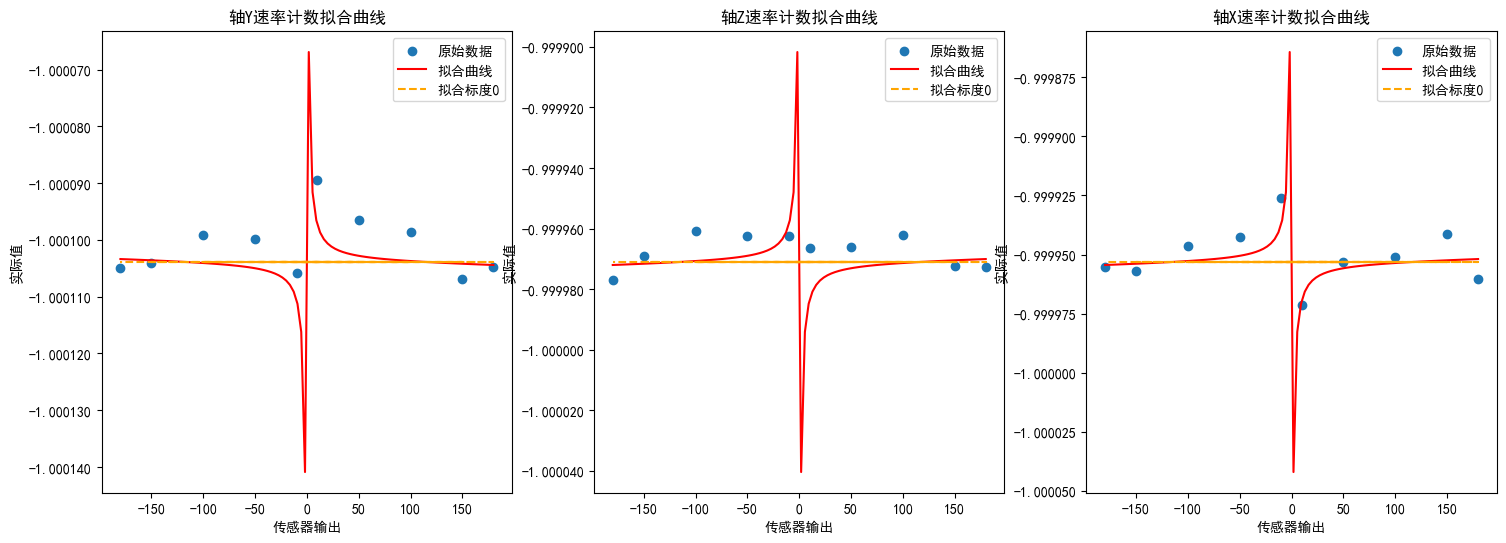

In [231]:
paths = 'E:\\Work\\理工导航\\General_autoTest_Host\\test_fun\\data\\all_ave'
names = 'SL_26_1_s_txt.txt'
df = pd.read_csv(os.path.join(paths, names), encoding='gb2312', delim_whitespace=True)

degree = 2
save_data_accuracy = 6
sl_sort_list = [1,2,0]
sl_point_list = [10,50,100,150,180]
sl_para_list = [1,1,1]
if type(sl_point_list)==int:
    sl_point_list*=2
    sl_point_length = sl_point_list
elif type(sl_point_list)==list:
    sl_point_list = [i*j for i in sl_point_list for j in [1,-1]]
    sl_point_length = len(sl_point_list)
else:
    print('速率计数点数输入错误，默认5点')
def get_max_abs_with_sign(s):
    s = s.replace('[', '').replace(']', '')
    parts = s.split('_')
    nums = []
    for pnum in parts:
        try: nums.append(float(pnum))
        except: pass
    if not nums: 
        return None
    max_num = max(nums, key=lambda x: abs(x))
    return max_num

sdf = init_sdf()
if df.columns[0].lower() == 'turntable':
    # 将第一列用下划线分隔并获取绝对值最大的数据,保留正负
    df.iloc[:,0] = df.iloc[:,0].apply(get_max_abs_with_sign)
fig,ax = plt.subplots(1,3,figsize=(18,6))
for count,i in enumerate(sl_sort_list):
    data_x = df.iloc[count*sl_point_length:(count+1)*sl_point_length,i+1].reset_index(drop=True)
    data_x_lw = data_x.mean()
    # data_x -= data_x_lw
    if type(sl_point_list)==list:
        data_y = pd.Series(sl_point_list).reset_index(drop=True)
    else:
        data_y = df.iloc[count*sl_point_length:(count+1)*sl_point_length,0].reset_index(drop=True)
    fits = np.polyfit(data_x-data_x_lw, data_y, degree)
    y_fit = np.polyval(fits, data_y)
    errors = data_x-data_x_lw - y_fit
    # print('count:{},i:{} data_x:{} data_y:{}'.format(count,i,data_x.tolist(),data_y.tolist()))
    data_y_new = np.linspace(data_y.min(), data_y.max(), 100)  
    y_fit_new = np.polyval(fits, data_y_new)
    ax[count].scatter(data_y, (data_x-data_x_lw)/data_y, label='原始数据')
    ax[count].plot(y_fit_new, data_y_new/y_fit_new, color='red', label='拟合曲线')
    # ax[count].scatter(data_y, (data_x-data_x_lw-errors)/data_y, label="残差", color="green", marker="x")
    # ax[count].scatter(data_y, ((data_x-data_x_lw)/data_y) + (errors/data_y), label="残差", color="green", marker="x")
    # ax[count].scatter(data_y, (data_x-data_x_lw)/data_y-1e-6,label="残差", color="green", marker="x")
    ax[count].plot(data_y,1/fits[-2]*data_y/data_y,label='拟合标度0', color='orange', linestyle='--')
    ax[count].set_xlabel('传感器输出')
    ax[count].set_ylabel('实际值')
    ax[count].set_title('轴{}速率计数拟合曲线'.format('XYZ'[i]))
    ax[count].legend()
    # 取消科学计数法
    ax[count].yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax[count].yaxis.get_major_formatter().set_scientific(False)
    ax[count].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.6f}'.format(y)))
    
    
    
    

In [225]:
fits = np.polyfit(data_x-data_x_lw, data_y, degree)
fits

array([ 1.19752712e-08, -1.00004683e+00, -1.61651020e-04])

In [227]:
print(data_x-data_x_lw)
print(data_y)
print(fits)

0     -9.999714
1      9.999262
2    -49.997663
3     49.997120
4    -99.995122
5     99.994648
6   -149.991188
7    149.993566
8   -179.992838
9    179.991933
Name: Gx(deg/h), dtype: float64
0     10
1    -10
2     50
3    -50
4    100
5   -100
6    150
7   -150
8    180
9   -180
dtype: int64
[ 1.19752712e-08 -1.00004683e+00 -1.61651020e-04]
